In [114]:
# processing
#import d6tflow, luigi, d6tpipe
import pandas as pd
import numpy as np
import pathlib

# viz
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import TimeSeriesSplit
import lightgbm
#lightgbm.LGBMRegressor
import shap
#shap.initjs()
from pymc3 import summary

# project
# import cfg, tasks
# import importlib # optional
# importlib.reload(cfg)
# importlib.reload(tasks)
# importlib.reload(visualize)

# Data Overview

In [115]:
# read original data
df = pd.read_csv('train.csv',names=['Store','Dept','Date','weeklySales','isHoliday'],header=0)
features = pd.read_csv('features.csv',names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2',
                                             'MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment','IsHoliday'],
                      header=0).drop(columns=['IsHoliday'])
stores = pd.read_csv('stores.csv',names=['Store','Type','Size'],header=0)

# merge data into panel data
df = df.merge(stores,how='left').merge(features,how='left')

In [116]:
print(df.columns)

Index(['Store', 'Dept', 'Date', 'weeklySales', 'isHoliday', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment'],
      dtype='object')


In [117]:
df

,Store,Dept,Date,weeklySales,isHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684
421566,45,98,2012-10-05,628.10,False,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667
421567,45,98,2012-10-12,1061.02,False,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667
421568,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667


In [118]:
print('observations and type')
df.info()

observations and type
<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   weeklySales   421570 non-null  float64
 4   isHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [119]:
print('missing values')
df.apply(lambda x:x.isna().sum()/len(x))

missing values


Store           0.000000
Dept            0.000000
Date            0.000000
weeklySales     0.000000
isHoliday       0.000000
Type            0.000000
Size            0.000000
Temperature     0.000000
Fuel_Price      0.000000
MarkDown1       0.642572
MarkDown2       0.736110
MarkDown3       0.674808
MarkDown4       0.679847
MarkDown5       0.640790
CPI             0.000000
Unemployment    0.000000
dtype: float64

In [120]:
print('unique values')
df.apply(lambda x: len(x.unique()))

unique values


Store               45
Dept                81
Date               143
weeklySales     359464
isHoliday            2
Type                 3
Size                40
Temperature       3528
Fuel_Price         892
MarkDown1         2278
MarkDown2         1500
MarkDown3         1663
MarkDown4         1945
MarkDown5         2294
CPI               2145
Unemployment       349
dtype: int64

In [121]:
df.describe().round(2)

,Store,Dept,weeklySales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.00,421570.00,421570.00,421570.00,421570.00,421570.00,150681.00,111248.00,137091.00,134967.00,151432.00,421570.00,421570.00
mean,22.20,44.26,15981.26,136727.92,60.09,3.36,7246.42,3334.63,1439.42,3383.17,4628.98,171.20,7.96
std,12.79,30.49,22711.18,60980.58,18.45,0.46,8291.22,9475.36,9623.08,6292.38,5962.89,39.16,1.86
min,1.00,1.00,-4988.94,34875.00,-2.06,2.47,0.27,-265.76,-29.10,0.22,135.16,126.06,3.88
25%,11.00,18.00,2079.65,93638.00,46.68,2.93,2240.27,41.60,5.08,504.22,1878.44,132.02,6.89
50%,22.00,37.00,7612.03,140167.00,62.09,3.45,5347.45,192.00,24.60,1481.31,3359.45,182.32,7.87
75%,33.00,74.00,20205.85,202505.00,74.28,3.74,9210.90,1926.94,103.99,3595.04,5563.80,212.42,8.57
max,45.00,99.00,693099.36,219622.00,100.14,4.47,88646.76,104519.54,141630.61,67474.85,108519.28,227.23,14.31


# Distribution of Target Variable

Text(0.5, 1.0, 'Weekly Sales')

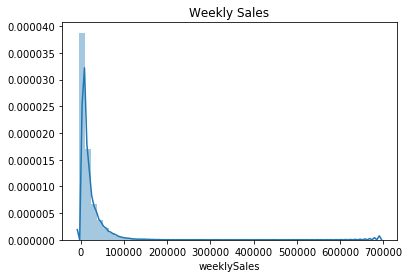

In [122]:
sns.distplot(df['weeklySales']).set_title('Weekly Sales')

# Distribution of Input Variables

In [123]:
inputs = list(df.columns)
inputs.remove('Date')
inputs.remove('isHoliday')
inputs.remove('Type')

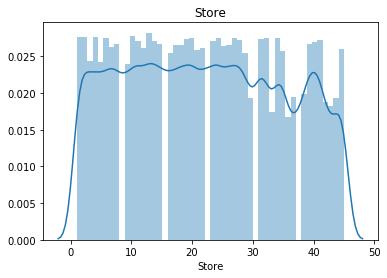

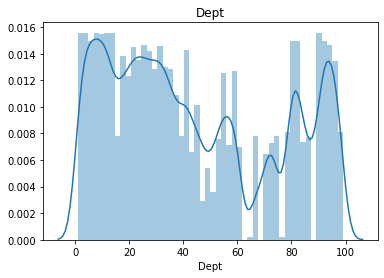

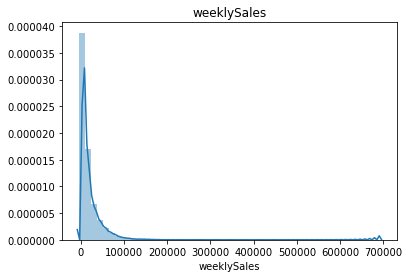

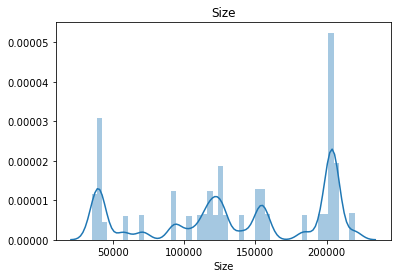

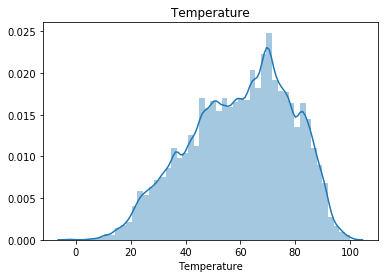

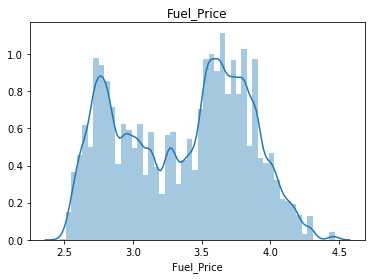

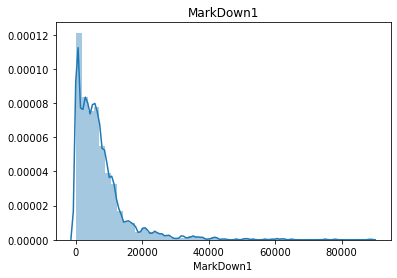

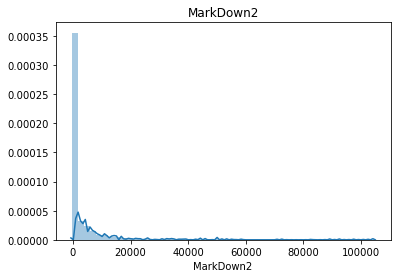

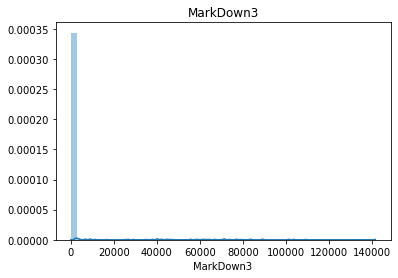

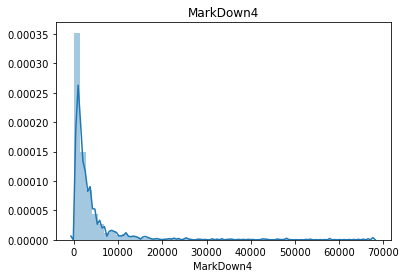

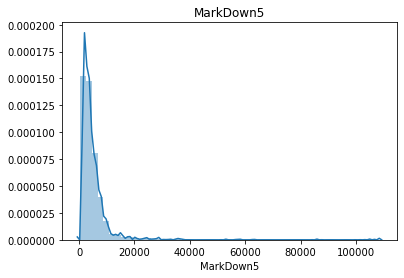

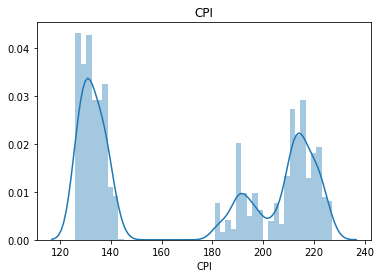

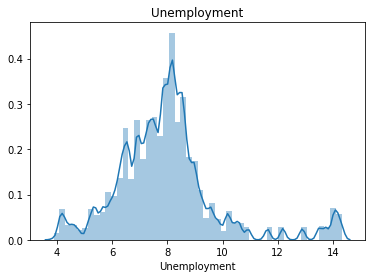

In [124]:
for icol in inputs:
    plt.figure();
    sns.distplot(df[icol]).set_title(icol);

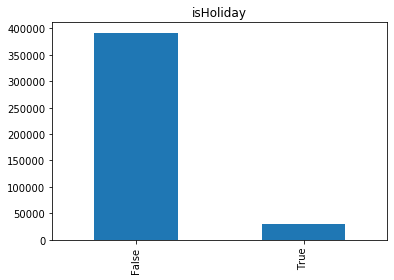

In [125]:
df['isHoliday'].value_counts().plot(kind='bar',title='isHoliday')

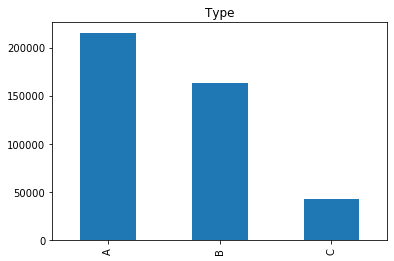

In [126]:
df['Type'].value_counts().plot(kind='bar',title='Type')

# Relation of Input Variables to Target Variable

In [127]:
inputs = list(df.columns)
inputs.remove('weeklySales')
inputs.remove('Date')
inputs.remove('isHoliday')
inputs.remove('Type')
inputs.remove('Store')
inputs.remove('Dept')

<Figure size 432x288 with 0 Axes>

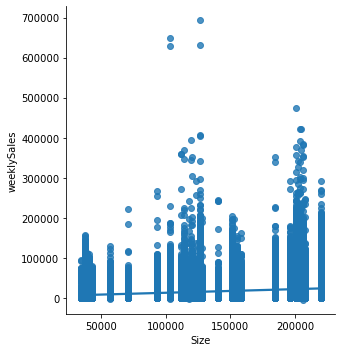

<Figure size 432x288 with 0 Axes>

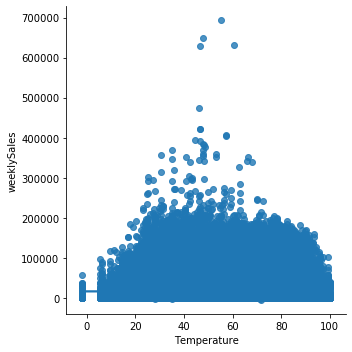

<Figure size 432x288 with 0 Axes>

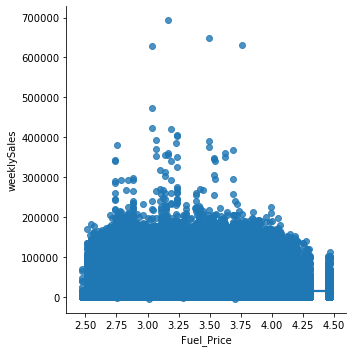

<Figure size 432x288 with 0 Axes>

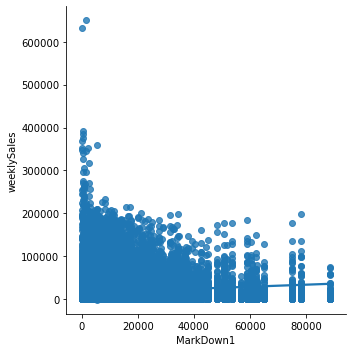

<Figure size 432x288 with 0 Axes>

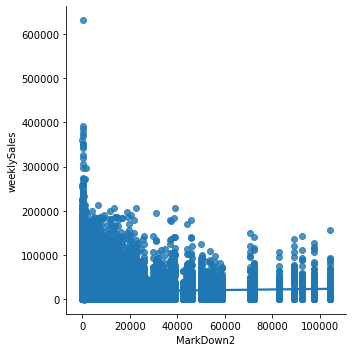

<Figure size 432x288 with 0 Axes>

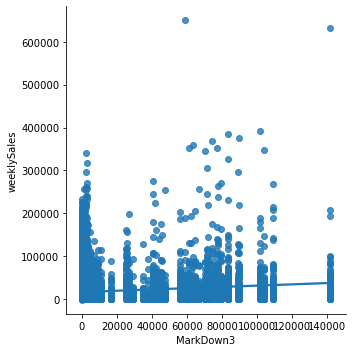

<Figure size 432x288 with 0 Axes>

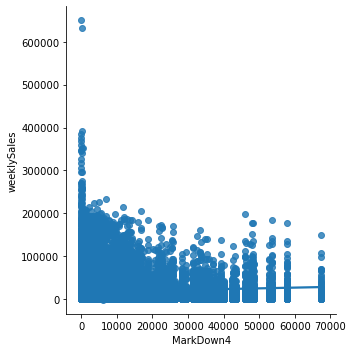

<Figure size 432x288 with 0 Axes>

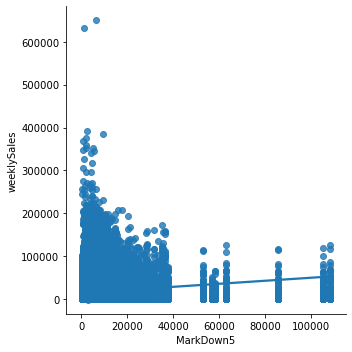

<Figure size 432x288 with 0 Axes>

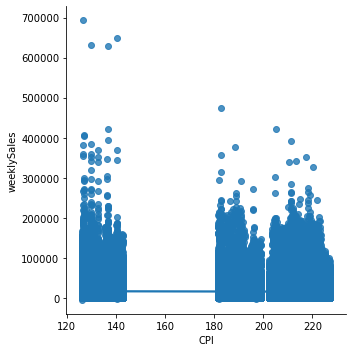

<Figure size 432x288 with 0 Axes>

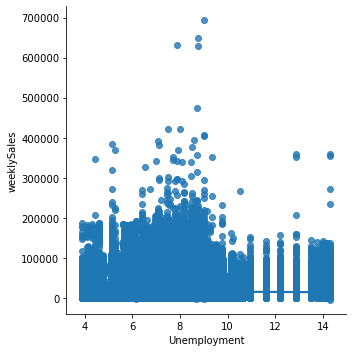

In [128]:
for icol in inputs:
    plt.figure();
    sns.lmplot(x=icol, y='weeklySales', data=df, ci=None);

In [129]:
def scatter(dataset,column):
    plt.figure()
    plt.scatter(dataset[column],dataset['weeklySales'])
    plt.ylabel('weeklySales')
    plt.xlabel(column)

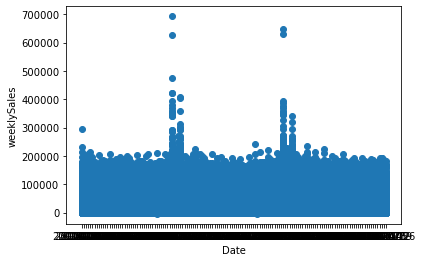

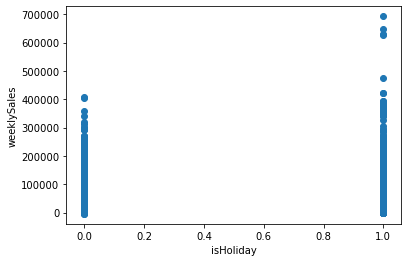

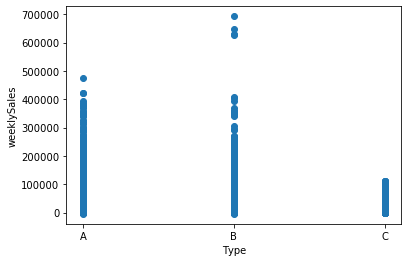

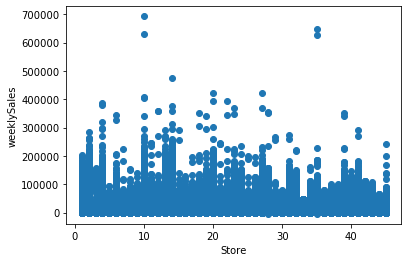

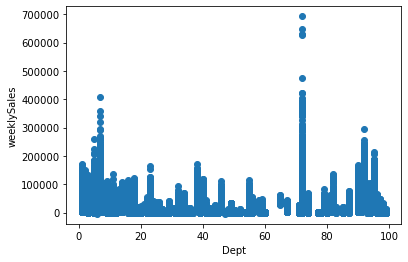

In [130]:
scatter(df,'Date')
scatter(df,'isHoliday')
scatter(df,'Type')
scatter(df,'Store')
scatter(df,'Dept')

In [131]:
df.groupby(['Store','Dept'])['weeklySales'].mean()

Store  Dept
1      1       22513.322937
       2       46102.090420
       3       13150.478042
       4       36964.154476
       5       24257.941119
                   ...     
45     94       3690.272090
       95      52896.166643
       96          2.970000
       97       6466.961888
       98        561.239037
Name: weeklySales, Length: 3331, dtype: float64

# Correlation Heatmap

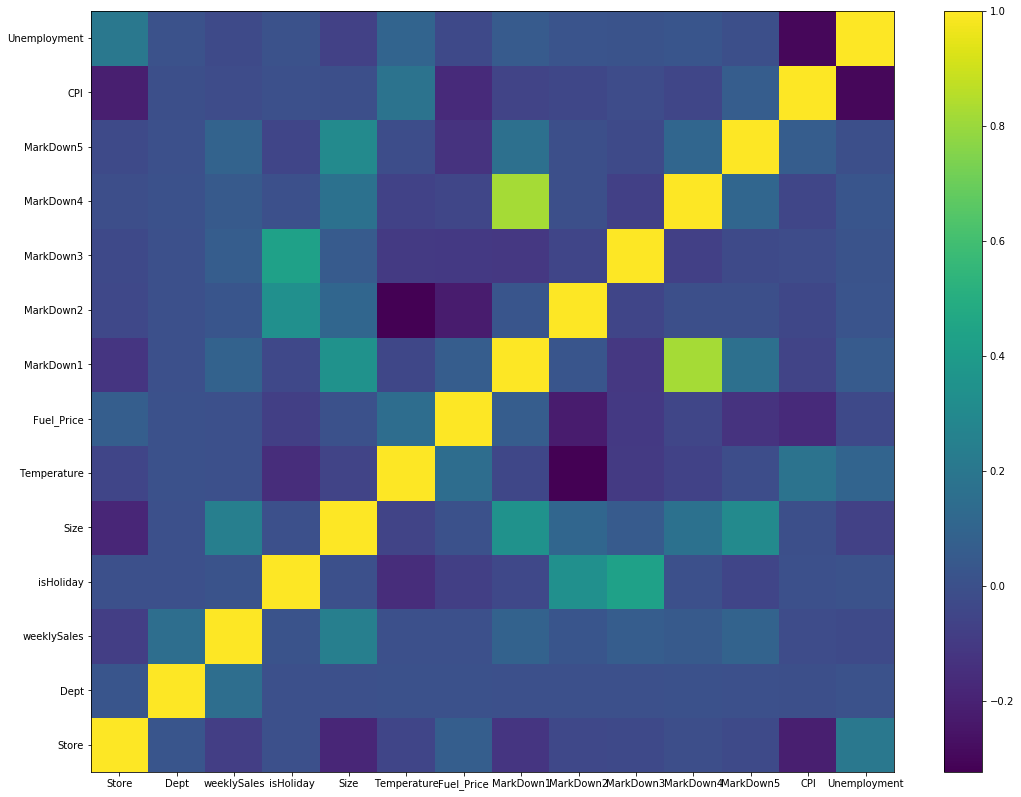

In [132]:
fig = plt.figure(figsize=(18,14))
corr = df.corr()
c = plt.pcolor(corr)
plt.yticks(np.arange(0.5,len(corr.index),1),corr.index)
plt.xticks(np.arange(0.5,len(corr.columns),1),corr.columns)
fig.colorbar(c)

# Pair Plots

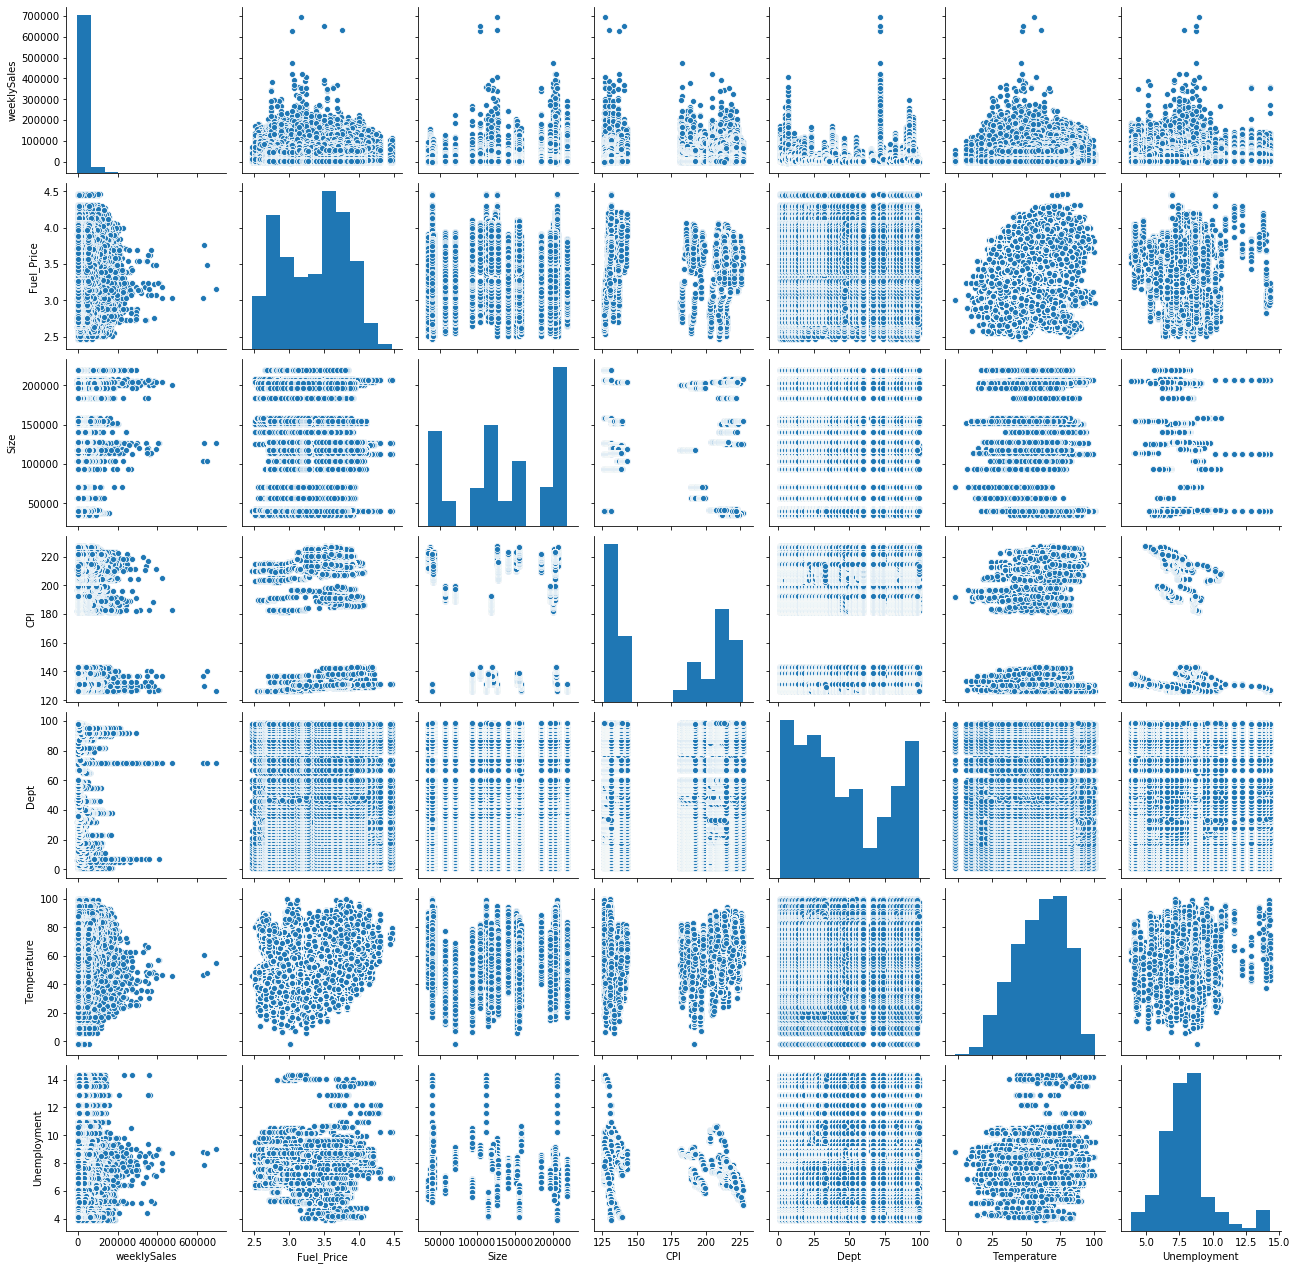

In [133]:
sns.pairplot(df,vars=['weeklySales','Fuel_Price','Size','CPI','Dept','Temperature','Unemployment'])

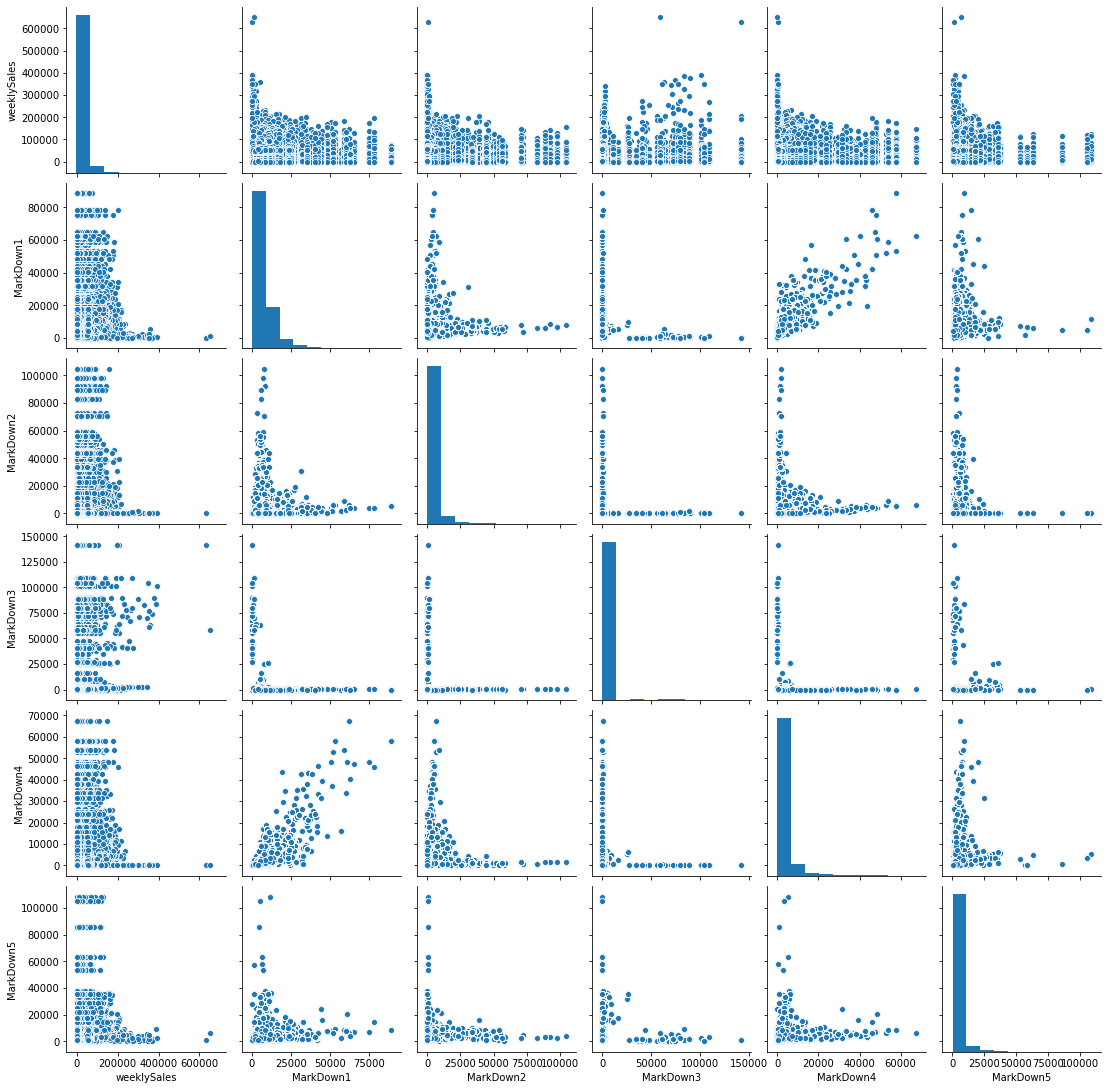

In [134]:
sns.pairplot(df,vars=['weeklySales','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])

# Data Manipulation

In [135]:
# Convert "Type" to dummy variables
df = pd.get_dummies(df,columns=['Type'],drop_first=True)

In [136]:
# fill in NaN with 0
df[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']] = df[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)

In [137]:
# create "Year", "Month" and "Day" variables to maybe find out some trends and seasonality
df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Day'] = pd.to_datetime(df['Date']).dt.day

In [138]:
df

,Store,Dept,Date,weeklySales,isHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type_B,Type_C,Year,Month,Day
0,1,1,2010-02-05,24924.50,False,151315,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,0,0,2010,2,5
1,1,1,2010-02-12,46039.49,True,151315,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,0,0,2010,2,12
2,1,1,2010-02-19,41595.55,False,151315,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,0,0,2010,2,19
3,1,1,2010-02-26,19403.54,False,151315,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,0,0,2010,2,26
4,1,1,2010-03-05,21827.90,False,151315,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,0,0,2010,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,1,0,2012,9,28
421566,45,98,2012-10-05,628.10,False,118221,64.89,3.985,5046.74,0.00,18.82,2253.43,2340.01,192.170412,8.667,1,0,2012,10,5
421567,45,98,2012-10-12,1061.02,False,118221,54.47,4.000,1956.28,0.00,7.89,599.32,3990.54,192.327265,8.667,1,0,2012,10,12
421568,45,98,2012-10-19,760.01,False,118221,56.47,3.969,2004.02,0.00,3.18,437.73,1537.49,192.330854,8.667,1,0,2012,10,19


In [139]:
lag_1 = []
lag_4 = []
lag_8 = []

for name,group in df.groupby(["Store","Dept"]):
    lag_1.append(group['weeklySales'].shift(1))
    lag_4.append(group['weeklySales'].shift(4))
    lag_8.append(group['weeklySales'].shift(8))
    
df['Lag Sales of 1 Week'] = pd.concat(lag_1)
df['Lag Sales of 4 Weeks'] = pd.concat(lag_4)
df['Lag Sales of 8 Weeks'] = pd.concat(lag_8)

In [140]:
m_2 = []
m_3 = []
m_4 = []
m_8 = []
target = []

for name,group in df.groupby(["Store","Dept"]):
    m_2.append(group['Lag Sales of 1 Week'].rolling(window=2).mean())
    m_3.append(group['Lag Sales of 1 Week'].rolling(window=3).mean())
    m_4.append(group['Lag Sales of 1 Week'].rolling(window=4).mean())
    m_8.append(group['Lag Sales of 1 Week'].rolling(window=8).mean())
    target.append(group['weeklySales'].shift(-1))
    
df['2-week Rolling Mean'] = pd.concat(m_2)
df['3-week Rolling Mean'] = pd.concat(m_3)
df['4-week Rolling Mean'] = pd.concat(m_4)
df['8-week Rolling Mean'] = pd.concat(m_8)
df['Target'] = pd.concat(target)

In [141]:
df = df.dropna()
df = df.drop(columns=['Date','weeklySales'])

In [142]:
df

,Store,Dept,isHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Month,Day,Lag Sales of 1 Week,Lag Sales of 4 Weeks,Lag Sales of 8 Weeks,2-week Rolling Mean,3-week Rolling Mean,4-week Rolling Mean,8-week Rolling Mean,Target
8,1,1,False,151315,62.27,2.719,0.00,0.00,0.00,0.00,...,4,2,26229.21,21827.90,24924.50,24182.925,23136.413333,22809.2850,27900.02750,42960.91
9,1,1,False,151315,65.86,2.770,0.00,0.00,0.00,0.00,...,4,9,57258.43,21043.39,46039.49,41743.820,35208.093333,31666.9175,31941.76875,17596.96
10,1,1,False,151315,66.32,2.808,0.00,0.00,0.00,0.00,...,4,16,42960.91,22136.64,41595.55,50109.670,42149.516667,37146.2975,31556.94625,16145.35
11,1,1,False,151315,64.84,2.795,0.00,0.00,0.00,0.00,...,4,23,17596.96,26229.21,19403.54,30278.935,39272.100000,36011.3775,28557.12250,16555.11
12,1,1,False,151315,67.41,2.780,0.00,0.00,0.00,0.00,...,4,30,16145.35,57258.43,21827.90,16871.155,25567.740000,33490.4125,28149.84875,17413.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421564,45,98,False,118221,65.32,4.038,8452.20,92.28,63.24,2376.38,...,9,21,605.96,415.40,657.63,479.200,434.813333,429.9600,515.19750,508.37
421565,45,98,False,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,...,9,28,467.30,346.04,516.46,536.630,475.233333,442.9350,491.40625,628.10
421566,45,98,False,118221,64.89,3.985,5046.74,0.00,18.82,2253.43,...,10,5,508.37,352.44,727.49,487.835,527.210000,483.5175,490.39500,1061.02
421567,45,98,False,118221,54.47,4.000,1956.28,0.00,7.89,599.32,...,10,12,628.10,605.96,500.16,568.235,534.590000,552.4325,477.97125,760.01


# Model Training

In [143]:
df['target_naive'] = df['Target'].mean()

In [144]:
mod_reg = LinearRegression().fit(df.loc[:,:'8-week Rolling Mean'],df['Target'])
df['target_reg'] = mod_reg.predict(df.loc[:,:'8-week Rolling Mean'])

In [145]:
mod_lgbm = lightgbm.LGBMRegressor(max_depth=2,learning_rate=0.1,n_estimators=100,reg_alpha=1.0)
mod_lgbm.fit(df.loc[:,:'8-week Rolling Mean'],df['Target'])
df['target_lgbm']=mod_lgbm.predict(df.loc[:,:'8-week Rolling Mean'])

In [146]:
df

,Store,Dept,isHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Lag Sales of 4 Weeks,Lag Sales of 8 Weeks,2-week Rolling Mean,3-week Rolling Mean,4-week Rolling Mean,8-week Rolling Mean,Target,target_naive,target_reg,target_lgbm
8,1,1,False,151315,62.27,2.719,0.00,0.00,0.00,0.00,...,21827.90,24924.50,24182.925,23136.413333,22809.2850,27900.02750,42960.91,16089.814639,23809.930441,25395.244149
9,1,1,False,151315,65.86,2.770,0.00,0.00,0.00,0.00,...,21043.39,46039.49,41743.820,35208.093333,31666.9175,31941.76875,17596.96,16089.814639,39195.266335,44748.984972
10,1,1,False,151315,66.32,2.808,0.00,0.00,0.00,0.00,...,22136.64,41595.55,50109.670,42149.516667,37146.2975,31556.94625,16145.35,16089.814639,38900.137349,40010.968235
11,1,1,False,151315,64.84,2.795,0.00,0.00,0.00,0.00,...,26229.21,19403.54,30278.935,39272.100000,36011.3775,28557.12250,16555.11,16089.814639,33435.580580,22429.971574
12,1,1,False,151315,67.41,2.780,0.00,0.00,0.00,0.00,...,57258.43,21827.90,16871.155,25567.740000,33490.4125,28149.84875,17413.94,16089.814639,23972.695932,19860.241001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421564,45,98,False,118221,65.32,4.038,8452.20,92.28,63.24,2376.38,...,415.40,657.63,479.200,434.813333,429.9600,515.19750,508.37,16089.814639,1702.576383,623.889460
421565,45,98,False,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,...,346.04,516.46,536.630,475.233333,442.9350,491.40625,628.10,16089.814639,1265.167692,994.932109
421566,45,98,False,118221,64.89,3.985,5046.74,0.00,18.82,2253.43,...,352.44,727.49,487.835,527.210000,483.5175,490.39500,1061.02,16089.814639,1654.322992,651.598143
421567,45,98,False,118221,54.47,4.000,1956.28,0.00,7.89,599.32,...,605.96,500.16,568.235,534.590000,552.4325,477.97125,760.01,16089.814639,1569.723722,817.534616


# Model Evaluation

### Prediction Error: in-sample

In [147]:
print('naive mean',mean_squared_error(df['Target'],df['target_naive']))
print('linear regression',mean_squared_error(df['Target'],df['target_reg']))
print('gbm',mean_squared_error(df['Target'],df['target_lgbm']))

naive mean 518669364.42215586
linear regression 46797344.71511956
gbm 41130166.95951833


### Prediction Error: cross-validation

In [148]:
cv_reg = []
cv_lgbm = []
tscv = TimeSeriesSplit()

X = df.loc[:,:'8-week Rolling Mean']
y = df['Target']

for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[list(train_index),:], X.iloc[list(test_index),:]
        y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]
        mod_reg = LinearRegression().fit(X_train,y_train)
        mod_lgbm = lightgbm.LGBMRegressor(max_depth=2,learning_rate=0.1,n_estimators=100,reg_alpha=1.0).fit(X_train,y_train)
        cv_reg.append(mean_squared_error(y_test,mod_reg.predict(X_test)))
        cv_lgbm.append(mean_squared_error(y_test,mod_lgbm.predict(X_test)))      

print('linear regression',np.array(cv_reg).mean())
print('gbm',np.array(cv_lgbm).mean())


linear regression 47944410.44242913
gbm 42541324.05368972


# Model Interpretation (Feature Importance)

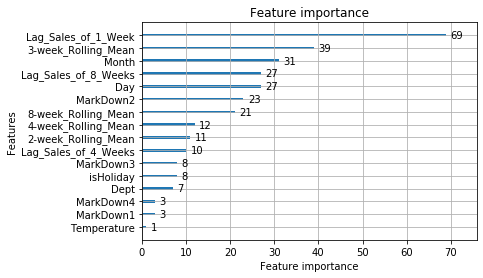

In [149]:
mod_lgbm = lightgbm.LGBMRegressor(max_depth=2,learning_rate=0.1,n_estimators=100,reg_alpha=1.0)
mod_lgbm.fit(df.loc[:,:'8-week Rolling Mean'],df['Target'])
lightgbm.plot_importance(mod_lgbm)

# Panel Regression Techniques

In [271]:
from linearmodels.panel import PanelOLS
from linearmodels.panel import PooledOLS
from linearmodels.panel import RandomEffects
data = pd.read_csv('walmart_cleaned.csv')
data['Store'] = data['Store'].apply(str)
data['Dept'] = data['Dept'].apply(str)
data['Store-Dept'] = data['Store']+","+data['Dept']
data = data.drop(columns=['Store','Dept'])
data['Date'] = pd.to_datetime(data['Date']) 

data['Lag Sales of 1 Week'] = pd.concat(lag_1)
data['Lag Sales of 4 Weeks'] = pd.concat(lag_4)
data['Lag Sales of 8 Weeks'] = pd.concat(lag_8)

data['2-week Rolling Mean'] = pd.concat(m_2)
data['3-week Rolling Mean'] = pd.concat(m_3)
# data['4-week Rolling Mean'] = pd.concat(m_4)   Not included due to collinearity
data['8-week Rolling Mean'] = pd.concat(m_8)
data['Target'] = pd.concat(target)

data = data.dropna()
data = data.drop(columns=['weeklySales'])

data = data.set_index(['Store-Dept','Date'])
dependent = data['Target']
exog = sm.add_constant(data.loc[:,'isHoliday':'8-week Rolling Mean'])

### PooledOLS Model

In [272]:
mod = PooledOLS(dependent, exog)
res = mod.fit(cov_type='robust')
res

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Dep. Variable:,Target,R-squared:,0.9091
Estimator:,PooledOLS,R-squared (Between):,0.9994
No. Observations:,392424,R-squared (Within):,0.0908
Date:,"Tue, Aug 18 2020",R-squared (Overall):,0.9091
Time:,12:05:28,Log-likelihood,-4.024e+06
Cov. Estimator:,Robust,,
,,F-statistic:,2.065e+05
Entities:,3167,P-value,0.0000
Avg Obs:,123.91,Distribution:,"F(19,392404)"
Min Obs:,1.0000,,
Max Obs:,134.00,F-statistic (robust):,5.19e+04


In [273]:
data['PooledOLS Prediction'] = res.predict(sm.add_constant(data[['isHoliday','Size','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment','Type_B','Type_C','Lag Sales of 1 Week','Lag Sales of 4 Weeks','Lag Sales of 8 Weeks','2-week Rolling Mean','3-week Rolling Mean','8-week Rolling Mean']]))
print("PooledOLS",mean_squared_error(data['Target'],data['PooledOLS Prediction']))

PooledOLS 47148839.549758896


### PanelOLS Model

In [274]:
mod = PanelOLS(dependent, exog, entity_effects=False, time_effects=True, drop_absorbed=True)
res = mod.fit(cov_type='robust')
res

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

Variables have been fully absorbed and have removed from the regression:

isHoliday



Dep. Variable:,Target,R-squared:,0.9148
Estimator:,PanelOLS,R-squared (Between):,0.9995
No. Observations:,392424,R-squared (Within):,0.0882
Date:,"Tue, Aug 18 2020",R-squared (Overall):,0.9089
Time:,12:05:33,Log-likelihood,-4.01e+06
Cov. Estimator:,Robust,,
,,F-statistic:,2.341e+05
Entities:,3167,P-value,0.0000
Avg Obs:,123.91,Distribution:,"F(18,392272)"
Min Obs:,1.0000,,
Max Obs:,134.00,F-statistic (robust):,4.771e+04


In [275]:
data['PanelOLS Prediction'] = res.predict(sm.add_constant(data[['Size','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment','Type_B','Type_C','Lag Sales of 1 Week','Lag Sales of 4 Weeks','Lag Sales of 8 Weeks','2-week Rolling Mean','3-week Rolling Mean','8-week Rolling Mean']]))
print("PanelOLS",mean_squared_error(data['Target'],data['PanelOLS Prediction']))

PanelOLS 47260403.19652578


### Random Effects

In [276]:
mod = RandomEffects(dependent, exog)
res = mod.fit(cov_type='robust')
res

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Dep. Variable:,Target,R-squared:,0.9091
Estimator:,RandomEffects,R-squared (Between):,0.9994
No. Observations:,392424,R-squared (Within):,0.0908
Date:,"Tue, Aug 18 2020",R-squared (Overall):,0.9091
Time:,12:05:38,Log-likelihood,-4.024e+06
Cov. Estimator:,Robust,,
,,F-statistic:,2.065e+05
Entities:,3167,P-value,0.0000
Avg Obs:,123.91,Distribution:,"F(19,392404)"
Min Obs:,1.0000,,
Max Obs:,134.00,F-statistic (robust):,5.19e+04


In [277]:
data['Random Effects Prediction'] = res.predict(sm.add_constant(data[['isHoliday','Size','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment','Type_B','Type_C','Lag Sales of 1 Week','Lag Sales of 4 Weeks','Lag Sales of 8 Weeks','2-week Rolling Mean','3-week Rolling Mean','8-week Rolling Mean']]))
print("Random Effects",mean_squared_error(data['Target'],data['Random Effects Prediction']))

Random Effects 47148839.549758896


# Hierarchical Modeling

In [278]:
from sklearn.preprocessing import StandardScaler

In [279]:
data.reset_index(level=0,inplace=True)
data.reset_index(level=0,inplace=True)

In [280]:
import theano
import pymc3 as pm
data['Size'] = data['Size'].astype(float)
data['isHoliday'] = data['isHoliday'].astype(float)
data['Type_B'] = data['Type_B'].astype(float)
data['Type_C'] = data['Type_C'].astype(float)
data['Target'] = data['Target'].astype(theano.config.floatX)
data['log_target'] = np.log(data['Target']).astype(theano.config.floatX)
data = data[data.Target != 0]
data.loc[:,"Size":"8-week Rolling Mean"] = StandardScaler().fit_transform(data.loc[:,"Size":"8-week Rolling Mean"])

In [281]:
data = data.sort_values(by=['Date'])

In [367]:
train_data = data.iloc[:-40000,:]
test_data = data.iloc[-40000:,:]

In [368]:
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz, HalfNormal

train_data["Store-Dept"] = train_data["Store-Dept"].map(str.strip)
ind = train_data["Store-Dept"].unique()
combinations = len(ind)
combination_lookup = dict(zip(ind, range(len(ind))))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [369]:
combination = train_data['combination_code'] = train_data["Store-Dept"].replace(combination_lookup).values


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [370]:
train_data

,Date,Store-Dept,isHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Lag Sales of 8 Weeks,2-week Rolling Mean,3-week Rolling Mean,8-week Rolling Mean,Target,PooledOLS Prediction,PanelOLS Prediction,Random Effects Prediction,log_target,combination_code
0,2010-04-02,"1,1",0.0,0.236957,0.058209,-1.525426,-0.440295,-0.179134,-0.087057,-0.287499,...,0.386064,0.359601,0.315064,0.534176,42960.91,24087.482010,23803.151767,24087.482010,10.668046,0
296570,2010-04-02,"33,79",0.0,-1.595316,0.306445,-0.698158,-0.440295,-0.179134,-0.087057,-0.287499,...,-0.326898,-0.255267,-0.254766,-0.247108,11479.26,9940.562184,9924.652629,9940.562184,9.348297,1
296704,2010-04-02,"33,80",0.0,-1.595316,0.306445,-0.698158,-0.440295,-0.179134,-0.087057,-0.287499,...,-0.259397,-0.255440,-0.237404,-0.250960,10958.36,10653.270132,10582.388419,10653.270132,9.301858,2
42393,2010-04-02,"5,46",0.0,-1.674352,0.108186,-1.525426,-0.440295,-0.179134,-0.087057,-0.287499,...,-0.508767,-0.527897,-0.517536,-0.528345,5290.88,4634.954882,4556.634689,4634.954882,8.573740,3
296838,2010-04-02,"33,81",0.0,-1.595316,0.306445,-0.698158,-0.440295,-0.179134,-0.087057,-0.287499,...,-0.270020,-0.326426,-0.306883,-0.294749,10699.58,9318.093159,9247.168898,9318.093159,9.277960,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388636,2012-07-20,"45,42",0.0,-0.306266,0.970968,0.386081,0.634814,-0.174522,-0.084801,0.272603,...,-0.481264,-0.502983,-0.503295,-0.509758,4660.15,5336.635846,5327.186103,5336.635846,8.446803,2821
312510,2012-07-20,"35,35",0.0,-0.544933,0.957238,0.386081,0.192684,-0.179134,-0.082502,-0.054857,...,-0.573365,-0.600223,-0.601201,-0.596767,2568.72,3012.565284,3082.595657,3012.565284,7.851163,212
198509,2012-07-20,"22,46",0.0,-0.284336,0.843555,0.483009,0.082703,-0.159862,-0.084333,0.206984,...,0.429841,0.442642,0.471807,0.452080,20887.22,25737.549284,25919.337103,25737.549284,9.946893,2449
24565,2012-07-20,"3,46",0.0,-1.633037,1.107717,-0.190977,-0.236507,-0.166540,-0.086384,-0.250251,...,-0.410851,-0.424030,-0.425782,-0.428957,6462.87,6382.987431,6497.126825,6382.987431,8.773829,1331


In [194]:
with Model() as hierarchical_model:
    
    # hyperpriors for slopes
    mu_inter = Normal('mu_inter', mu=8.5, sigma=10)
    sigma_inter = HalfNormal('sigma_inter', 5.)
    mu_size = Normal('mu_size', mu=0., sigma=10)
    sigma_size = HalfNormal('sigma_size', 5.)
#    mu_typeb = Normal('mu_typeb', mu=0., sigma=100)
#    sigma_typeb = HalfNormal('sigma_typeb', 5.)
#    mu_typec = Normal('mu_typec', mu=0., sigma=1000)
#    sigma_typec = HalfNormal('sigma_typec', 5.)
    mu_holi = Normal('mu_holi', mu=0., sigma=10)
    sigma_holi = HalfNormal('sigma_holi', 5.)
#    mu_temp = Normal('mu_temp', mu=0., sigma=30)
#    sigma_temp = HalfNormal('sigma_temp', 5.)
#    mu_fuel = Normal('mu_fuel', mu=0., sigma=1000)
#    sigma_fuel = HalfNormal('sigma_fuel', 5.)
    mu_mkd1 = Normal('mu_mkd1', mu=0., sigma=10)
    sigma_mkd1 = HalfNormal('sigma_mkd1', 5.)
    mu_mkd2 = Normal('mu_mkd2', mu=0., sigma=10)
    sigma_mkd2 = HalfNormal('sigma_mkd2', 5.)
    mu_mkd3 = Normal('mu_mkd3', mu=0., sigma=10)
    sigma_mkd3 = HalfNormal('sigma_mkd3', 5.)
    mu_mkd4 = Normal('mu_mkd4', mu=0., sigma=10)
    sigma_mkd4 = HalfNormal('sigma_mkd4', 5.)
    mu_mkd5 = Normal('mu_mkd5', mu=0., sigma=10)
    sigma_mkd5 = HalfNormal('sigma_mkd5', 5.)
#    mu_cpi = Normal('mu_cpi', mu=0., sigma=1)
#    sigma_cpi = HalfNormal('sigma_cpi', 5.)
#    mu_unemp = Normal('mu_unemp', mu=0., sigma=20)
#    sigma_unemp = HalfNormal('sigma_unemp', 5.)
    mu_lag1 = Normal('mu_lag1', mu=0., sigma=10)
    sigma_lag1 = HalfNormal('sigma_lag1', 5.)
    mu_lag4 = Normal('mu_lag4', mu=0., sigma=10)
    sigma_lag4 = HalfNormal('sigma_lag4', 5.)
    mu_lag8 = Normal('mu_lag8', mu=0., sigma=10)
    sigma_lag8 = HalfNormal('sigma_lag8', 5.)
    mu_mean2 = Normal('mu_mean2', mu=0., sigma=10)
    sigma_mean2 = HalfNormal('sigma_mean2', 5.)
    mu_mean3 = Normal('mu_mean3', mu=0., sigma=10)
    sigma_mean3 = HalfNormal('sigma_mean3', 5.)
    mu_mean8 = Normal('mu_mean8', mu=0., sigma=10)
    sigma_mean8 = HalfNormal('sigma_mean8', 5.)
    
    # slopes
    inter = Normal('inter',mu=mu_inter,sigma=sigma_inter,shape=combinations)
    size = Normal('size',mu=mu_size,sigma=sigma_size,shape=combinations)
#    typeb = Normal('typeb',mu=mu_typeb,sigma=sigma_typeb,shape=combinations)
#    typec = Normal('typec',mu=mu_typec,sigma=sigma_typec,shape=combinations)
    holi = Normal('holi',mu=mu_holi,sigma=sigma_holi,shape=combinations)
#    temp = Normal('temp',mu=mu_temp,sigma=sigma_temp,shape=combinations)
#    fuel = Normal('fuel',mu=mu_fuel,sigma=sigma_fuel,shape=combinations)
    mkd1 = Normal('mkd1',mu=mu_mkd1,sigma=sigma_mkd1,shape=combinations)
    mkd2 = Normal('mkd2',mu=mu_mkd2,sigma=sigma_mkd2,shape=combinations)
    mkd3 = Normal('mkd3',mu=mu_mkd3,sigma=sigma_mkd3,shape=combinations)
    mkd4 = Normal('mkd4',mu=mu_mkd4,sigma=sigma_mkd4,shape=combinations)
    mkd5 = Normal('mkd5',mu=mu_mkd5,sigma=sigma_mkd5,shape=combinations)
#    cpi = Normal('cpi',mu=mu_cpi,sigma=sigma_cpi,shape=combinations)
#    unemp = Normal('unemp',mu=mu_unemp,sigma=sigma_unemp,shape=combinations)
    lag1 = Normal('lag1',mu=mu_lag1,sigma=sigma_lag1,shape=combinations)
    lag4 = Normal('lag4',mu=mu_lag4,sigma=sigma_lag4,shape=combinations)
    lag8 = Normal('lag8',mu=mu_lag8,sigma=sigma_lag8,shape=combinations)
    mean2 = Normal('mean2',mu=mu_mean2,sigma=sigma_mean2,shape=combinations)
    mean3 = Normal('mean3',mu=mu_mean3,sigma=sigma_mean3,shape=combinations)
    mean8 = Normal('mean8',mu=mu_mean8,sigma=sigma_mean8,shape=combinations)
    
    # Model error
    eps = HalfCauchy('eps',5.)

    # Expected value
    y_hat = inter[combination] + mkd1[combination]*train_data['MarkDown1'].values + mkd2[combination]*train_data['MarkDown2'].values + mkd3[combination]*train_data['MarkDown3'].values + mkd4[combination]*train_data['MarkDown4'].values + mkd5[combination]*train_data['MarkDown5'].values + size[combination]*train_data['Size'].values + holi[combination]*train_data['isHoliday'].values + lag1[combination]*train_data['Lag Sales of 1 Week'].values + lag4[combination]*train_data['Lag Sales of 4 Weeks'].values + lag8[combination]*train_data['Lag Sales of 8 Weeks'].values + mean2[combination]*train_data['2-week Rolling Mean'].values + mean3[combination]*train_data['3-week Rolling Mean'].values + mean8[combination]*train_data['8-week Rolling Mean'].values

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=eps, observed=train_data.log_target)   

Data in y_like contains missing values and will be automatically imputed from the sampling distribution.


In [196]:
with hierarchical_model:
    hierarchical_trace = sample(100, chains=2, tune=100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [y_like_missing, eps, mean8, mean3, mean2, lag8, lag4, lag1, mkd5, mkd4, mkd3, mkd2, mkd1, holi, size, inter, sigma_mean8, mu_mean8, sigma_mean3, mu_mean3, sigma_mean2, mu_mean2, sigma_lag8, mu_lag8, sigma_lag4, mu_lag4, sigma_lag1, mu_lag1, sigma_mkd5, mu_mkd5, sigma_mkd4, mu_mkd4, sigma_mkd3, mu_mkd3, sigma_mkd2, mu_mkd2, sigma_mkd1, mu_mkd1, sigma_holi, mu_holi, sigma_size, mu_size, sigma_inter, mu_inter]
Sampling 2 chains, 16 divergences: 100%|██████████| 400/400 [8:20:14<00:00, 75.04s/draws]  
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.66938896

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

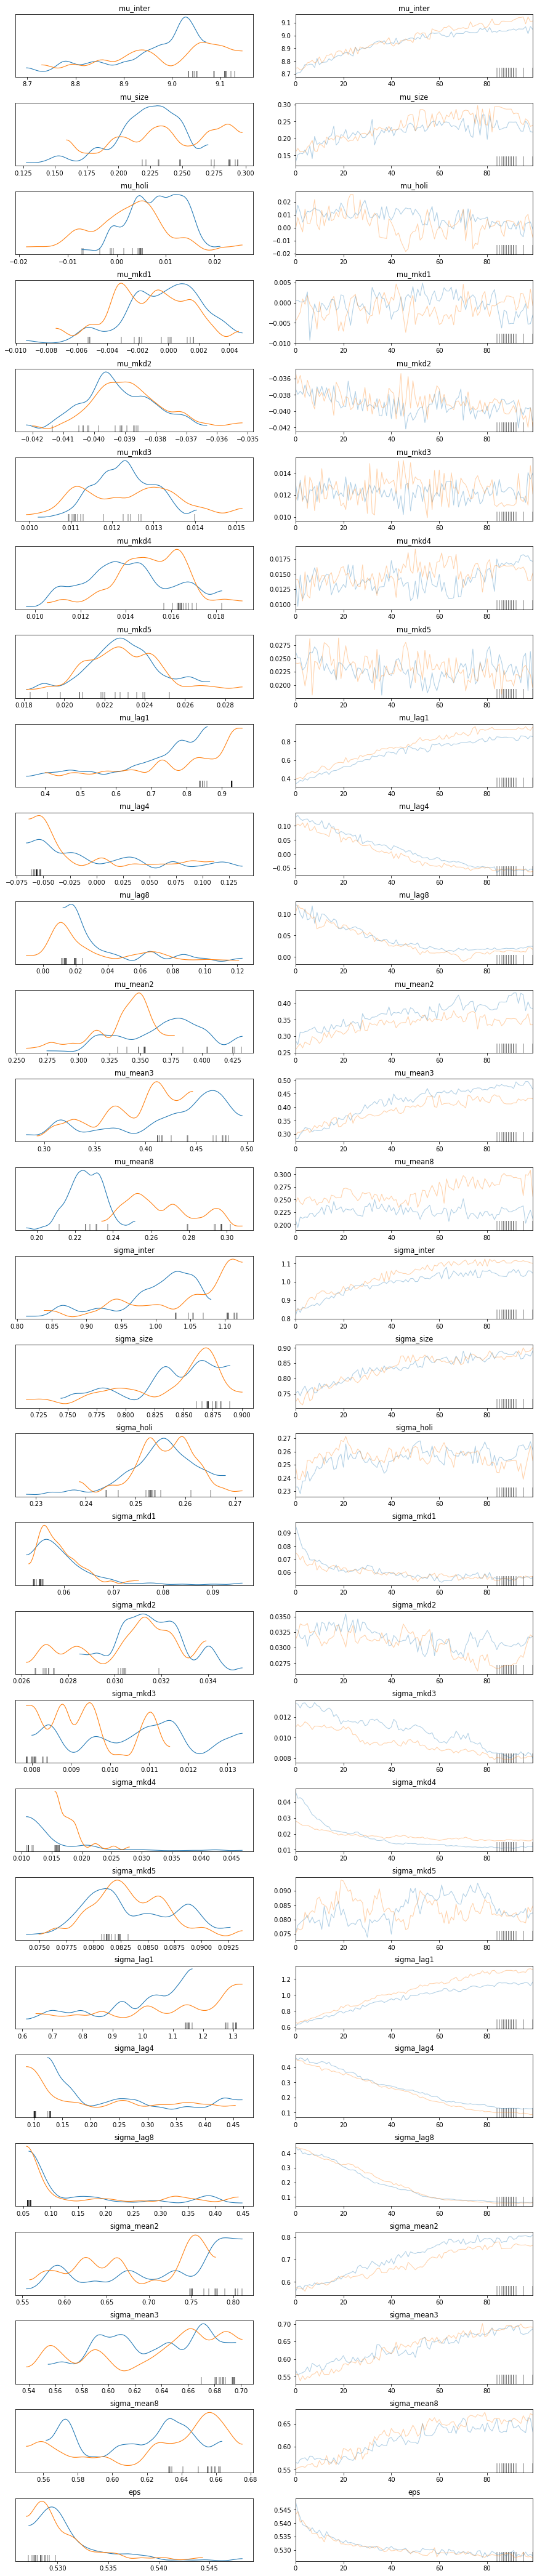

In [286]:
pm.traceplot(hierarchical_trace,
             var_names=['mu_inter', 'mu_size', 'mu_holi', 'mu_mkd1', 'mu_mkd2', 'mu_mkd3', 'mu_mkd4', 'mu_mkd5', 'mu_lag1', 'mu_lag4', 'mu_lag8', 'mu_mean2', 'mu_mean3', 'mu_mean8',
                        'sigma_inter', 'sigma_size', 'sigma_holi', 'sigma_mkd1', 'sigma_mkd2', 'sigma_mkd3', 'sigma_mkd4', 'sigma_mkd5', 'sigma_lag1', 'sigma_lag4', 'sigma_lag8', 'sigma_mean2', 'sigma_mean3', 'sigma_mean8',
                        'eps']);

In [287]:
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(
    hierarchical_trace, var_names=["inter","size","holi","mkd1","mkd2","mkd3","mkd4","mkd5","lag1","lag4","lag8","mean2","mean3","mean8","y_like"], random_seed=602
    )

100%|██████████| 200/200 [00:09<00:00, 21.88it/s]


In [288]:
ppc["y_like"].shape

(200, 352382)

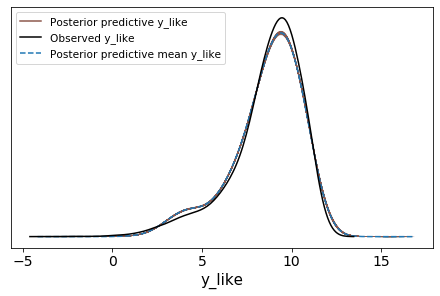

In [289]:
import arviz as az
idata = az.from_pymc3(hierarchical_trace, posterior_predictive=ppc)
az.plot_ppc(idata);

In [290]:
ppc["y_like"] = np.transpose(ppc["y_like"])

In [291]:
ppc["y_like"].shape

(352382, 200)

In [292]:
ppc["y_like"].mean(axis=1)

array([10.00854096,  9.26980107,  9.19361293, ..., 10.04815543,
        8.69836389,  9.08072229])

In [373]:
train_data["Predicted_log"] = ppc["y_like"].mean(axis=1)
train_data["Predicted_target"] = np.exp(train_data["Predicted_log"])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [374]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("In-sample RMSE: ",np.sqrt(mean_squared_error(train_data["Target"],train_data["Predicted_target"])))
print("In-sample R-Squared: ",r2_score(train_data["Target"],train_data["Predicted_target"]))

In-sample RMSE:  13781.734579283817
In-sample R-Squared:  0.6366841039462894


In [375]:
var_names=["inter","size","holi","mkd1","mkd2","mkd3","mkd4","mkd5","lag1","lag4","lag8","mean2","mean3","mean8"]
mean_slope = []
for var in var_names:
    mean_slope.append(np.transpose(hierarchical_trace[var]).mean(axis=1))

In [376]:
hierarchical_trace[inter].shape

(200, 3160)

In [377]:
test_data.head()

,Date,Store-Dept,isHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Lag Sales of 4 Weeks,Lag Sales of 8 Weeks,2-week Rolling Mean,3-week Rolling Mean,8-week Rolling Mean,Target,PooledOLS Prediction,PanelOLS Prediction,Random Effects Prediction,log_target
173201,2012-07-20,"19,85",0.0,1.098787,0.821588,0.758014,0.529708,-0.098441,-0.083923,0.476859,...,-0.533363,-0.506611,-0.536874,-0.537509,-0.521095,4888.97,4729.494704,4768.488516,4729.494704,8.494737
26232,2012-07-20,"3,81",0.0,-1.633037,1.107717,-0.190977,-0.236507,-0.166540,-0.086384,-0.250251,...,-0.625373,-0.630527,-0.630517,-0.632795,-0.643878,1944.71,1966.040339,2069.618625,1966.040339,7.572868
40979,2012-07-20,"5,31",0.0,-1.674352,1.089594,-0.190977,-0.285076,-0.176569,-0.086461,-0.218059,...,-0.685348,-0.686876,-0.694297,-0.699139,-0.708376,882.24,518.424124,645.208098,518.424124,6.782464
97498,2012-07-20,"11,56",0.0,1.159192,1.164284,-0.190977,0.022195,-0.152458,-0.079152,0.630997,...,-0.622353,-0.582702,-0.675098,-0.672701,-0.636255,630.70,2028.000251,2112.400160,2028.000251,6.446830
198720,2012-07-20,"22,52",0.0,-0.284336,0.843555,0.483009,0.082703,-0.159862,-0.084333,0.206984,...,-0.648221,-0.596842,-0.645695,-0.648306,-0.649071,2191.90,2184.065443,2279.411839,2184.065443,7.692524


In [378]:
test_data = test_data[test_data['Store-Dept'].isin(train_data['Store-Dept'])]

In [379]:
test_data

,Date,Store-Dept,isHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Lag Sales of 4 Weeks,Lag Sales of 8 Weeks,2-week Rolling Mean,3-week Rolling Mean,8-week Rolling Mean,Target,PooledOLS Prediction,PanelOLS Prediction,Random Effects Prediction,log_target
173201,2012-07-20,"19,85",0.0,1.098787,0.821588,0.758014,0.529708,-0.098441,-0.083923,0.476859,...,-0.533363,-0.506611,-0.536874,-0.537509,-0.521095,4888.97,4729.494704,4768.488516,4729.494704,8.494737
26232,2012-07-20,"3,81",0.0,-1.633037,1.107717,-0.190977,-0.236507,-0.166540,-0.086384,-0.250251,...,-0.625373,-0.630527,-0.630517,-0.632795,-0.643878,1944.71,1966.040339,2069.618625,1966.040339,7.572868
40979,2012-07-20,"5,31",0.0,-1.674352,1.089594,-0.190977,-0.285076,-0.176569,-0.086461,-0.218059,...,-0.685348,-0.686876,-0.694297,-0.699139,-0.708376,882.24,518.424124,645.208098,518.424124,6.782464
97498,2012-07-20,"11,56",0.0,1.159192,1.164284,-0.190977,0.022195,-0.152458,-0.079152,0.630997,...,-0.622353,-0.582702,-0.675098,-0.672701,-0.636255,630.70,2028.000251,2112.400160,2028.000251,6.446830
198720,2012-07-20,"22,52",0.0,-0.284336,0.843555,0.483009,0.082703,-0.159862,-0.084333,0.206984,...,-0.648221,-0.596842,-0.645695,-0.648306,-0.649071,2191.90,2184.065443,2279.411839,2184.065443,7.692524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75707,2012-10-19,"9,19",0.0,-0.181318,0.373446,0.446943,-0.352500,-0.179134,-0.085650,-0.280294,...,-0.629123,-0.659543,-0.651635,-0.653307,-0.660925,1730.33,1721.155643,1799.263321,1721.155643,7.456067
222035,2012-10-19,"25,8",0.0,-0.143991,-0.509656,1.292244,0.061938,-0.179134,-0.083280,-0.253530,...,0.608945,0.603703,0.743514,0.718081,0.676338,32508.41,31579.601602,31413.694362,31579.601602,10.389254
222169,2012-10-19,"25,9",0.0,-0.143991,-0.509656,1.292244,0.061938,-0.179134,-0.083280,-0.253530,...,-0.093473,-0.141518,-0.109637,-0.081034,-0.121306,11117.87,14259.807730,14122.830086,14259.807730,9.316309
71291,2012-10-19,"8,74",0.0,0.298725,0.097751,0.446943,-0.237493,-0.179134,-0.085914,-0.217549,...,-0.351551,-0.134345,-0.358941,-0.354269,-0.310473,9268.34,9262.784813,9206.794989,9262.784813,9.134360


In [380]:
predicted_log = []

for i in range(len(test_data)):
    predicted_log.append(mean_slope[0][combination_lookup[test_data.iloc[i,1]]]+mean_slope[1][combination_lookup[test_data.iloc[i,1]]]*test_data.iloc[i,3]+mean_slope[2][combination_lookup[test_data.iloc[i,1]]]*test_data.iloc[i,2]+mean_slope[3][combination_lookup[test_data.iloc[i,1]]]*test_data.iloc[i,6]+mean_slope[4][combination_lookup[test_data.iloc[i,1]]]*test_data.iloc[i,7]+mean_slope[5][combination_lookup[test_data.iloc[i,1]]]*test_data.iloc[i,8]+mean_slope[6][combination_lookup[test_data.iloc[i,1]]]*test_data.iloc[i,9]+mean_slope[7][combination_lookup[test_data.iloc[i,1]]]*test_data.iloc[i,10]+mean_slope[8][combination_lookup[test_data.iloc[i,1]]]*test_data.iloc[i,15]+mean_slope[9][combination_lookup[test_data.iloc[i,1]]]*test_data.iloc[i,16]+mean_slope[10][combination_lookup[test_data.iloc[i,1]]]*test_data.iloc[i,17]+mean_slope[11][combination_lookup[test_data.iloc[i,1]]]*test_data.iloc[i,18]+mean_slope[12][combination_lookup[test_data.iloc[i,1]]]*test_data.iloc[i,19]+mean_slope[13][combination_lookup[test_data.iloc[i,1]]]*test_data.iloc[i,20])
        

In [381]:
test_data["Predicted_log"] = predicted_log


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [382]:
test_data["Predicted_target"] = np.exp(test_data["Predicted_log"])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [383]:
test_data.head()

,Date,Store-Dept,isHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,2-week Rolling Mean,3-week Rolling Mean,8-week Rolling Mean,Target,PooledOLS Prediction,PanelOLS Prediction,Random Effects Prediction,log_target,Predicted_log,Predicted_target
173201,2012-07-20,"19,85",0.0,1.098787,0.821588,0.758014,0.529708,-0.098441,-0.083923,0.476859,...,-0.536874,-0.537509,-0.521095,4888.97,4729.494704,4768.488516,4729.494704,8.494737,8.400679,4450.086399
26232,2012-07-20,"3,81",0.0,-1.633037,1.107717,-0.190977,-0.236507,-0.166540,-0.086384,-0.250251,...,-0.630517,-0.632795,-0.643878,1944.71,1966.040339,2069.618625,1966.040339,7.572868,7.298841,1478.585502
40979,2012-07-20,"5,31",0.0,-1.674352,1.089594,-0.190977,-0.285076,-0.176569,-0.086461,-0.218059,...,-0.694297,-0.699139,-0.708376,882.24,518.424124,645.208098,518.424124,6.782464,6.362873,579.909969
97498,2012-07-20,"11,56",0.0,1.159192,1.164284,-0.190977,0.022195,-0.152458,-0.079152,0.630997,...,-0.675098,-0.672701,-0.636255,630.70,2028.000251,2112.400160,2028.000251,6.446830,7.411480,1654.874527
198720,2012-07-20,"22,52",0.0,-0.284336,0.843555,0.483009,0.082703,-0.159862,-0.084333,0.206984,...,-0.645695,-0.648306,-0.649071,2191.90,2184.065443,2279.411839,2184.065443,7.692524,7.326760,1520.447335


In [384]:
print("Out-sample RMSE: ",np.sqrt(mean_squared_error(test_data["Target"],test_data["Predicted_target"])))
print("Out-sample R-Squared: ",r2_score(test_data["Target"],test_data["Predicted_target"]))

Out-sample RMSE:  4012.485844642684
Out-sample R-Squared:  0.9666397776207776
